In [7]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import jax
import jax.numpy as jnp
import ilqrx.integrators as integrators
from modeling.dynamics.quadpend import QuadPend
jax.config.update("jax_enable_x64", True)
print(jax.devices())

[CudaDevice(id=0)]


In [8]:
from modeling.costs.lqr_cost import LQRCost
from dataclasses import dataclass

@dataclass
class QuadPendParams:
    Mass: float = 0.486
    mass: float = 0.2 * Mass
    grav: float = 9.81
    l: float = 0.25
    L: float = 2 * l
    J: float = 0.00383
    fric: float = 0.01

dt = 0.02
quadpend_params = QuadPendParams()

quadpend = QuadPend(dt=dt, integrator=integrators.euler)
dynamics = quadpend.dynamics_dt

nx = quadpend.state_dim
nu = quadpend.control_dim

# horizon
# T = 100
T = 150
# T = 200

x_target = jnp.array([3., -1.5, 0., 3.14159, 0., 0., 0., 0.])
u_target = jnp.array([2.860596, 2.860596])

Q = jnp.diag(jnp.array([5., 5., 100., 10., 5., 5., 10., 10.]))
Q *= 0.001
Qf = jnp.diag(jnp.array([100., 100., 10., 100., 50., 50., 10., 50.]))
Qf *= 2.
R = 0.01 * jnp.eye(nu)

cost_model = LQRCost(
    Q = Q, 
    R = R, 
    Qf = Qf, 
    x_ref = x_target, 
    u_ref = u_target, 
    T = T)

In [9]:
import jax
import jax.numpy as jnp 
from ilqrx.solvers import CILQRSolverOptions, CILQRSolver
from ilqrx.abstract_constraint import AbstractConstraint

x0 = jnp.array([-2.5, 1.5, 0., 0., 0., 0., 0., 0.])

# Provide an initial guess
U = jnp.zeros((T, nu))
X = jnp.zeros((T + 1, nx))
U = U.at[:].set(u_target)
for t in range(T + 1):
    X = X.at[t].set((1 - t / T) * x0 + (t / T) * x_target)


class DummyEqualityConstraint(AbstractConstraint):
    def constraint_fn(self, x, u, t):
        del x, u, t
        return jnp.empty(1)

class InequalityConstraint(AbstractConstraint):
    def __init__(self, obstacles, u_lb, u_ub, T, quadpend_params):
      super().__init__()
      self._obstacles = obstacles
      self._u_lb = u_lb
      self._u_ub = u_ub
      self._T = T
      self._quadpend_params = quadpend_params

    def _collision_avoidance_constraint(self, q):
      l = self._quadpend_params.l
      L = self._quadpend_params.L
      
      pos = q[:2]
      theta = q[2]
      phi = q[-1]

      R = jnp.array([[jnp.cos(theta), -jnp.sin(theta)],
                    [jnp.sin(theta), jnp.cos(theta)]])
      pos_c = pos + R @ jnp.array([0., 0.15*l])

      def avoid_obs(pos_c, ob):
        delta_body = pos_c - ob[0]
        body_dist_sq = jnp.vdot(delta_body, delta_body) - (ob[1] + l)**2

        pole_p = pos + jnp.array([L * jnp.sin(phi), -L * jnp.cos(phi)])
        delta_pole = pole_p - ob[0]
        pole_dist_sq = jnp.vdot(delta_pole, delta_pole) - (ob[1]**2)

        return jnp.array([-body_dist_sq, -pole_dist_sq])
      
      return jnp.concatenate([avoid_obs(pos_c, ob) for ob in obstacles])
    
    def constraint_fn(self, x, u, t):
        h_con = jnp.concatenate([u - self._u_ub, self._u_lb - u])
        h_con = jnp.where(t == self._T, jnp.zeros_like(h_con), h_con)
        h_obs = self._collision_avoidance_constraint(x[:4])
        return jnp.concatenate([h_con, h_obs])
    
obstacles = [
    (jnp.array([-1., 0.5]), 0.5),
    (jnp.array([0.75, -1.]), 0.75),
    (jnp.array([-2., -1.]), 0.5),
    (jnp.array([2., 1.]), 0.5)
]
u_lb = jnp.array([0.476766, 0.476766])
u_ub = jnp.array([14.30298, 14.30298])

inequality_constraint = InequalityConstraint(obstacles, u_lb, u_ub, T, quadpend_params)
equality_constraint = DummyEqualityConstraint()

In [10]:
from ilqrx.ocp import OptimalControlProblem

problem = OptimalControlProblem(dynamic_model=quadpend,
                                cost_model=cost_model,
                                equality_constraint_model=equality_constraint,
                                inequality_constraint_model=inequality_constraint)

solver_options = CILQRSolverOptions(max_iter=1000, 
                                    constr_vio_tol_init=0.01, 
                                    opti_tol_init=1.0, 
                                    rho_scaling=100.0, 
                                    rho_init=10.0, 
                                    rho_max=1e10)

solver = CILQRSolver(problem, options=solver_options)

In [11]:
cilqr_sol = solver.solve(X, U, verbose=True)

jax.block_until_ready(cilqr_sol.cost)

print(f"iLQR iterations: {cilqr_sol.num_iter}")
print(f"Optimal cost: {cilqr_sol.cost}")
print(f"Max constraint violation: {cilqr_sol.max_constr_vio}")
print(f"Solver status: {cilqr_sol.cilqr_status}")


╔═══ Starting CILQR Optimization ═══╗
---
iter |      cost        |  lag_x_inf_norm  |  lag_u_inf_norm  |  defect_inf_norm  |      alpha
 1   |   2.249244e+01   |   1.051730e+01   |   2.604673e+01   |   1.895263e+00    |   5.000000e-01  
 2   |   3.338613e+02   |   1.318687e+00   |   4.083913e+01   |   2.886475e-01    |   1.000000e+00  
 3   |   4.108398e+01   |   1.407910e-01   |   1.633494e+01   |   1.016228e-01    |   1.000000e+00  
 4   |   2.803905e+01   |   3.468961e-01   |   9.768057e+00   |   3.399435e-02    |   1.000000e+00  
 5   |   2.105801e+01   |   1.199824e-01   |   3.058645e+00   |   2.438837e-02    |   1.000000e+00  
 6   |   2.069547e+01   |   7.711440e-02   |   3.366508e+00   |   2.988546e-02    |   5.000000e-01  
 7   |   2.053074e+01   |   1.121259e-01   |   1.362058e+00   |   1.833387e-02    |   1.000000e+00  
 8   |   2.037674e+01   |   5.182869e-02   |   2.785293e-01   |   7.998808e-03    |   1.000000e+00  
┌─ CILQR Iteration (iter=0, rho=1.00e+01)
  Constraint

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


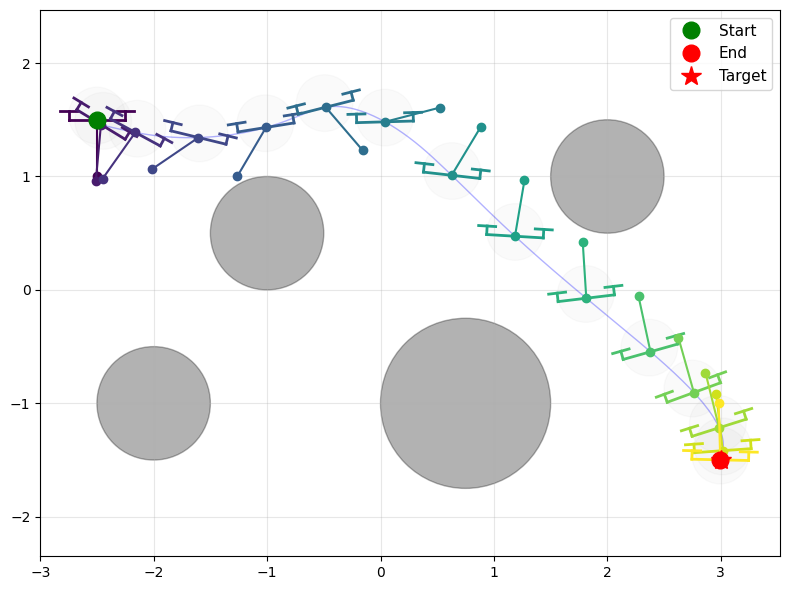


=== Snapshot Information ===
Snapshot 1 (t=0.0s): pos=(-2.50, 1.50), theta=0.000, phi=0.000
Snapshot 2 (t=0.2s): pos=(-2.46, 1.46), theta=-0.548, phi=-0.091
Snapshot 3 (t=0.4s): pos=(-2.16, 1.39), theta=-0.496, phi=-0.615
Snapshot 4 (t=0.6s): pos=(-1.60, 1.34), theta=-0.238, phi=-0.973
Snapshot 5 (t=0.8s): pos=(-1.01, 1.43), theta=0.159, phi=-0.531
Snapshot 6 (t=1.1s): pos=(-0.48, 1.61), theta=0.248, phi=0.709
Snapshot 7 (t=1.3s): pos=(0.04, 1.48), theta=0.029, phi=1.825
Snapshot 8 (t=1.5s): pos=(0.63, 1.01), theta=-0.112, phi=2.600
Snapshot 9 (t=1.7s): pos=(1.19, 0.47), theta=-0.059, phi=2.973
Snapshot 10 (t=1.9s): pos=(1.81, -0.07), theta=0.119, phi=3.205
Snapshot 11 (t=2.1s): pos=(2.38, -0.55), theta=0.275, phi=3.354
Snapshot 12 (t=2.3s): pos=(2.76, -0.90), theta=0.351, phi=3.416
Snapshot 13 (t=2.6s): pos=(2.99, -1.22), theta=0.306, phi=3.384
Snapshot 14 (t=2.8s): pos=(3.02, -1.42), theta=0.071, phi=3.259
Snapshot 15 (t=3.0s): pos=(3.00, -1.50), theta=-0.023, phi=3.169


In [12]:
from notebooks.utils import plot_snapshots
import numpy as np
L = quadpend_params.L
l = quadpend_params.l
quad_geo = (np.array([[-l, 0.],
                      [l, 0.]]),
            np.array([[-l, 0.],
                      [-l, 0.3*l]]),
            np.array([[l, 0.],
                     [l, 0.3*l]]),
            np.array([[-1.3*l, 0.3*l],
                      [-0.7*l, 0.3*l]]),
            np.array([[0.7*l, 0.3*l],
                      [1.3*l, 0.3*l]]))

plot_snapshots(cilqr_sol.X, dt, x_target, obstacles, quad_geo, quadpend_params, num_snapshots=15)